# This is the in situ and SSS collocation code. 


In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr
import scipy
from glob import glob
import cartopy.crs as ccrs
from pyresample.geometry import AreaDefinition
from pyresample import image, geometry, load_area, save_quicklook, SwathDefinition
from pyresample.kd_tree import resample_nearest
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

# Read in USV data
Read in the Saildrone USV file either from a local disc or using OpenDAP.



In [23]:
#filename_usv='f:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
filename_usv='f:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
ds_usv = xr.open_dataset(filename_usv)
ds_usv.close()
ds_usv = ds_usv.isel(trajectory=0).swap_dims({'obs':'time'}).rename({'longitude':'lon','latitude':'lat'})
ds_usv = ds_usv.sel(time=slice('2018-04-12T02','2018-06-10T18')) #get rid of last part and first part where USV being towed
ds_usv['lon'] = ds_usv.lon.interpolate_na(dim='time',method='linear') #there are 6 nan values
ds_usv['lat'] = ds_usv.lat.interpolate_na(dim='time',method='linear')
ds_usv['wind_speed']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)
ds_usv['wind_dir']=np.arctan2(ds_usv.VWND_MEAN,ds_usv.UWND_MEAN)*180/np.pi
ds_usv

<xarray.Dataset>
Dimensions:               (time: 85980)
Coordinates:
    trajectory            float32 1002.0
  * time                  (time) datetime64[ns] 2018-04-12T02:00:00 ... 2018-06-10T18:59:00
    lat                   (time) float64 37.51 37.51 37.51 ... 37.68 37.68 37.68
    lon                   (time) float64 -122.8 -122.8 -122.8 ... -122.7 -122.7
Data variables:
    SOG                   (time) float64 ...
    COG                   (time) float64 ...
    HDG                   (time) float64 ...
    HDG_WING              (time) float64 ...
    ROLL                  (time) float64 ...
    PITCH                 (time) float64 ...
    WING_ANGLE            (time) float64 ...
    BARO_PRES_MEAN        (time) float64 ...
    BARO_PRES_STDDEV      (time) float64 ...
    TEMP_AIR_MEAN         (time) float64 ...
    TEMP_AIR_STDDEV       (time) float64 ...
    RH_MEAN               (time) float64 ...
    RH_STDDEV             (time) float64 ...
    TEMP_IR_UNCOR_MEAN    (time) fl

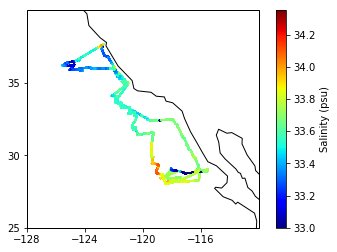

In [24]:
#plot cruise SSS with coastlines
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(ds_usv.lon, ds_usv.lat, s=3.0, c=ds_usv.SAL_MEAN, edgecolor='none', cmap='jet',vmin=33,vmax=34.35)
ax.coastlines()
x1,x2,y1,y2 = -128,-112,25,40
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Salinity (psu)')
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/baja_location.png'
plt.savefig(fig_fname, transparent=False, format='png')

## Here is the search code first step.  Narrow down what orbital files to search in

In [190]:
#search each day of USV data for min/max lat/lon 
#read in orbital files for that day and check to see if any valid data in that box

#intialize grid
area_def = load_area('areas.cfg', 'pc_world')
rlon=np.arange(-180,180,.1)
rlat=np.arange(90,-90,-.1)

#init filelist
file_save=[]

#search usv data
minday,maxday = ds_usv.time[0],ds_usv.time[-1]
usv_day = minday
print(minday.data,maxday.data)
while usv_day<=maxday:
    usv_day += np.timedelta64(1,'D')
    check_day = np.datetime64(str(usv_day.dt.year.data)+'-'+str(usv_day.dt.month.data).zfill(2)+'-'+str(usv_day.dt.day.data).zfill(2))
    usv_day1 = usv_day + np.timedelta64(1,'D')
    check_day1 = np.datetime64(str(usv_day1.dt.year.data)+'-'+str(usv_day1.dt.month.data).zfill(2)+'-'+str(usv_day1.dt.day.data).zfill(2))
    ds_day = ds_usv.sel(time=slice(check_day,check_day1))
    ilen = ds_day.time.size
    print(check_day,check_day1,ilen)
    if ilen<10:
        continue
    minlon,maxlon,minlat,maxlat = ds_day.lon.min().data,ds_day.lon.max().data,ds_day.lat.min().data,ds_day.lat.max().data
#caluclate filelist
    filelist = glob('F:/data/sat_data/smap/SSS/L2/RSS/V3/40km/'
                    +str(usv_day.dt.year.data)+'/'+str(usv_day.dt.dayofyear.data)+'/*.nc')   
    x,y,z = [],[],[]
    for file in filelist:
        ds = xr.open_dataset(file)
        ds.close()
        x = ds.cellon[:,:,0].data #np.append(x,ds.cellon[:,:,0].data)
        y = ds.cellat[:,:,0].data #np.append(y,ds.cellat[:,:,0].data)
        z = ds.sss_smap[:,:,0].data #np.append(z,ds.sss_smap[:,:,0].data)
        lons,lats,data = x,y,z 
        lons = np.mod(lons+180,360)-180
        swath_def = SwathDefinition(lons, lats)
        result1 = resample_nearest(swath_def, data, area_def, radius_of_influence=20000, fill_value=None)
        da = xr.DataArray(result1,name='sss',coords={'lat':rlat,'lon':rlon},dims=('lat','lon'))
        subset = da.sel(lat = slice(maxlat,minlat),lon=slice(minlon,maxlon))
        num_obs = np.isfinite(subset).sum()
        if num_obs>0:
            file_save = np.append(file_save,file)
df = xr.DataArray(file_save,name='filenames')
df.to_netcdf('C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/rss40km_filesave.nc')

2018-04-12T02:00:00.000000000 2018-06-10T18:59:00.000000000
2018-04-13 2018-04-14 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-04-14 2018-04-15 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-04-15 2018-04-16 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-04-16 2018-04-17 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-04-17 2018-04-18 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-04-18 2018-04-19 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-04-19 2018-04-20 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-04-20 2018-04-21 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-04-21 2018-04-22 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-04-22 2018-04-23 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-04-23 2018-04-24 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-04-24 2018-04-25 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-04-25 2018-04-26 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-04-26 2018-04-27 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-04-27 2018-04-28 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-04-28 2018-04-29 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-04-29 2018-04-30 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-04-30 2018-05-01 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-01 2018-05-02 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-02 2018-05-03 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-03 2018-05-04 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-04 2018-05-05 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-05 2018-05-06 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-06 2018-05-07 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-07 2018-05-08 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-08 2018-05-09 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-09 2018-05-10 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-10 2018-05-11 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-11 2018-05-12 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-12 2018-05-13 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-13 2018-05-14 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-14 2018-05-15 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-15 2018-05-16 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-16 2018-05-17 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-17 2018-05-18 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-18 2018-05-19 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-19 2018-05-20 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-20 2018-05-21 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-21 2018-05-22 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-22 2018-05-23 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-23 2018-05-24 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-24 2018-05-25 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-25 2018-05-26 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-26 2018-05-27 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-27 2018-05-28 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-28 2018-05-29 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-29 2018-05-30 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-30 2018-05-31 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-05-31 2018-06-01 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-06-01 2018-06-02 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-06-02 2018-06-03 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-06-03 2018-06-04 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-06-04 2018-06-05 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-06-05 2018-06-06 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-06-06 2018-06-07 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-06-07 2018-06-08 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-06-08 2018-06-09 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-06-09 2018-06-10 1441


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-06-10 2018-06-11 1140


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in remainder
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in greater_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\kd_tree.py:411: RuntimeWarning: invalid value encountered in less_equal
  (source_lats <= 90) & (source_lats >= -90))
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in greater_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pyresample\data_reduce.py:304: RuntimeWarning: invalid value encountered in less_equal
  valid_lats = (lats >= lat_min_buffered) * (lats <= lat_max_buffered)
C:\Users\gentemann\Miniconda3\envs\sate

2018-06-11 2018-06-12 0


In [26]:
#now read in orbits that have collocated data
#subset orbit to region USV has data on that day
#need to fill lat/lon nan with value for tree to build
#just picked -89 as it is outside usv observation region
from scipy import spatial
df = xr.open_dataset('C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/rss40km_filesave.nc')


numpy.datetime64('2000-01-01T00:00:00.000000000')

In [257]:
file = df.filenames[1].data
file = str(df.filenames[1].data)
file.replace('\\','/')
ds = xr.open_dataset(file)
ds.close()
lons = ds.cellon[:,:,0].fillna(-89).data #np.append(x,ds.cellon[:,:,0].data)
lats = ds.cellat[:,:,0].fillna(-89).data #np.append(y,ds.cellat[:,:,0].data)
inputdata = list(zip(lons.ravel(), lats.ravel()))
tree = spatial.KDTree(inputdata)
pts = np.array([ds_usv.lon[1000]+360, ds_usv.lat[1000]])
tree.query(pts,k=1)
i=tree.query(pts)[1]
ii=np.int(np.floor(i/1560))
jj=np.mod(i,1560)


In [256]:
ds.time[:,:,0].max()

<xarray.DataArray 'time' ()>
array('2018-04-14T15:17:28.670473000', dtype='datetime64[ns]')

In [239]:
print(tree.query(pts))
print(inputdata[tree.query(pts)[1]])
print([ds_usv.lon[1000].data+360, ds_usv.lat[1000].data])
print(len(inputdata))

(0.12456794107567877, 792031)
(237.6235, 36.88049)
[237.511616, array(36.8257344)]
1123200


In [240]:
print(ds_usv.lon[1000].data,ds_usv.lat[1000].data)
print(jj,ii, ii*1560+jj)
print(ds.cellon[ii,jj,0].data-360,ds.cellat[ii,jj,0].data)
print(lons[ii,jj]-360,lats[ii,jj])


-122.488384 36.8257344
1111 507 792031
-122.37649536132812 36.88049
-122.37649536132812 36.88049


(25, 40)

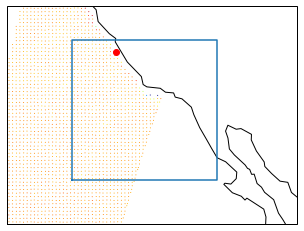

In [160]:
ds = xr.open_dataset(file)
ds.close()
x = ds.cellon[:,:,0].data
y = ds.cellat[:,:,0].data
z = ds.sss_smap[:,:,0].data
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(x, y, s=1.0, c=z, edgecolor='none', cmap='jet')
minlon,maxlon,minlat,maxlat = ds_usv.lon.min().data,ds_usv.lon.max().data,ds_usv.lat.min().data,ds_usv.lat.max().data
ax.plot([minlon,maxlon,maxlon,minlon,minlon],[minlat,minlat,maxlat,maxlat,minlat])
ax.plot(ds.cellon[jj,ii,0],ds.cellat[jj,ii,0],'b*')
ax.plot(ds_usv.lon[1000],ds_usv.lat[1000],'ro')
ax.coastlines()
ax.set_xlim(-130,-110)
ax.set_ylim(25,40)


In [129]:
np.nanmax(ds.cellon)

359.99933

In [66]:
minlon,maxlon,minlat,maxlat = ds_usv.lon.min().data,ds_usv.lon.max().data,ds_usv.lat.min().data,ds_usv.lat.max().data
print(minlon,maxlon,minlat,maxlat)
#cond = (lons>=minlon) & (lons<=maxlon) & (lats>=minlat) & (lats<=maxlat)
#meets_condition = (air_day.air > 22) & (air_day.air < 30)
#subset = ds.where((lons>=minlon) & (lons<=maxlon) & (lats>=minlat) & (lats<=maxlat),drop=True)
subset = ds.where((lons>=minlon) & (lons<=maxlon) & (lats>=minlat) & (lats<=maxlat))
print(subset)

-125.55297279999999 -115.5226624 28.0176832 37.6797408


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  


ValueError: operands could not be broadcast together with shapes (720,1560,2) (720,1560) () 

# Read in ACCESS data

In [17]:
filename = 'F:/data/cruise_data/access/rockfish_casts_2011.nc'
ds = xr.open_dataset(filename)
ds = ds.swap_dims({'row':'time'})
ds = ds.rename({'latitude':'lat','longitude':'lon'})
ds_access1 = ds.copy(deep=True)
filename = 'F:/data/cruise_data/access/rockfish_casts_2015.nc'
ds = xr.open_dataset(filename)
ds = ds.swap_dims({'row':'time'})
ds = ds.rename({'latitude':'lat','longitude':'lon'})
ds_access2 = ds.copy(deep=True)
ds_access = xr.concat((ds_access1,ds_access2),dim='time')

In [18]:
ds_access

<xarray.Dataset>
Dimensions:         (time: 151030)
Coordinates:
  * time            (time) datetime64[ns] 2011-05-03T08:02:00 ... 2015-06-14T11:51:00
Data variables:
    cruise          (time) |S4 b'1101' b'1101' b'1101' ... b'1505' b'1505'
    ctd_index       (time) int16 1 1 1 1 1 1 1 1 ... 246 246 246 246 246 246 246
    ctd_no          (time) int16 32767 32767 32767 32767 32767 ... 6 6 6 6 6
    station         (time) int16 473 473 473 473 473 473 ... 154 154 154 154 154
    lon             (time) float32 -124.106 -124.106 ... -123.19917 -123.19917
    lat             (time) float32 39.834167 39.834167 ... 37.6605 37.6605
    depth           (time) int16 2 4 6 8 10 12 14 ... 498 500 502 504 506 508
    temperature     (time) float32 9.8669 9.8627 9.8572 ... 6.2409 6.2327 6.2257
    salinity        (time) float32 33.016 33.0333 33.0427 ... 34.2127 34.213
    density         (time) float32 25.4252 25.4394 25.4477 ... 26.9066 26.9077
    dyn_hgt         (time) float32 nan nan nan nan

In [19]:
ds_access.time.dt.month

<xarray.DataArray 'month' (time: 151030)>
array([5, 5, 5, ..., 6, 6, 6], dtype=int64)
Coordinates:
  * time     (time) datetime64[ns] 2011-05-03T08:02:00 ... 2015-06-14T11:51:00

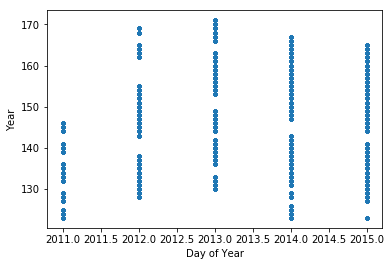

In [21]:
plt.plot(ds_access.time.dt.year,ds_access.time.dt.dayofyear,'.')
plt.xlabel('Day of Year')
plt.ylabel('Year')
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/access_date.png'
plt.savefig(fig_fname, transparent=False, format='png')

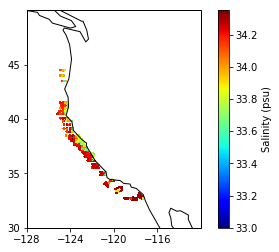

In [46]:
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(ds_access.lon, ds_access.lat, s=3.0, c=ds_access.salinity, edgecolor='none', cmap='jet',vmin=33,vmax=34.35)
ax.coastlines()
x1,x2,y1,y2 = -128,-112,30,50
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Salinity (psu)')
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/access_location.png'
plt.savefig(fig_fname, transparent=False, format='png')

# Read in 2018 Saildrone West Coast Survey

In [140]:
#https://coastwatch.pfeg.noaa.gov/erddap/
#url = 'https://coastwatch.pfeg.noaa.gov/erddap/tabledap/saildrone_west_coast_survey_2018.nc'
#url = 'https://ferret.pmel.noaa.gov/pmel/erddap/tabledap/saildrone_west_coast_survey_2018.nc'
url = 'https://ferret.pmel.noaa.gov/pmel/erddap/tabledap/saildrone_west_coast_survey_2018'
#url = 'F:/data/cruise_data/saildrone/2018_wcoast/saildrone_west_coast_survey_2018_f374_2e74_3de8.nc'
#url = 'https://ferret.pmel.noaa.gov/pmel/erddap/tabledap/saildrone_west_coast_survey_2018.nc'
ds_usv = xr.open_dataset(url)
ds_usv.close()
ds_usv['lat']=ds_usv['s.latitude']
ds_usv['lon']=ds_usv['s.longitude']
ds_usv['time']=ds_usv['s.time']
ds_usv['trajectory']=ds_usv['s.trajectory']
ds_usv['SAL_MEAN']=ds_usv['s.SAL_MEAN']
ds_usv['TEMP_CTD_MEAN']=ds_usv['s.TEMP_CTD_MEAN']
ds_usv = ds_usv.swap_dims({'s':'time'})
#print(ds_usv.time.min().data,ds_usv.time.max().data)
#ds_usv.load()


In [141]:
#used this code to figure out where the data goes bad
ilen = ds_usv.SAL_MEAN.size
print(ilen)
tem = np.nan(ilen)
for i in range(787066):
    if ds_usv.SAL_MEAN[i]>20:
        tem[i]=ds_usv.SAL_MEAN[i]
tem[i:]=np.nan

787066


TypeError: 'float' object is not callable

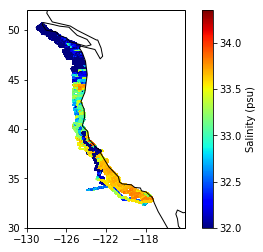

In [113]:
#there is something bad in the data file above 776100 so subset the data to just the good part
ds_usv2 = ds_usv.isel(time=slice(None,776100))
xlon =  ds_usv2.lon.copy(deep=True)
xlat =  ds_usv2.lat.copy(deep=True)
salinity = ds_usv2.SAL_MEAN.copy(deep=True)
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(xlon, xlat, s=3.0, c=salinity, edgecolor='none', cmap='jet',vmin=32,vmax=34.35)
ax.coastlines()
x1,x2,y1,y2 = -130,-114,30,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Salinity (psu)')
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/wcoast_location2.png'
plt.savefig(fig_fname, transparent=False, format='png')


In [125]:
ds_usv2.trajectory[0:5]

<xarray.DataArray 'trajectory' (time: 5)>
array([b'1024.0', b'1025.0', b'1026.0', b'1027.0', b'1028.0'], dtype='|S64')
Coordinates:
  * time     (time) datetime64[ns] 2018-07-17T18:00:00 ... 2018-07-17T18:04:00
Attributes:
    axis:           E
    cf_role:        trajectory_id
    comment:        A trajectory is a single deployment of a drone
    long_name:      Trajectory/Drone ID
    point_spacing:  even

In [126]:
url = 'https://ferret.pmel.noaa.gov/pmel/erddap/tabledap/saildrone_west_coast_survey_2018'
#url = 'F:/data/cruise_data/saildrone/2018_wcoast/saildrone_west_coast_survey_2018_f374_2e74_3de8.nc'
#url = 'https://ferret.pmel.noaa.gov/pmel/erddap/tabledap/saildrone_west_coast_survey_2018.nc'
ds_usv = xr.open_dataset(url)
ds_usv.close()
ds_usv

<xarray.Dataset>
Dimensions:                          (s: 787066)
Dimensions without coordinates: s
Data variables:
    s.trajectory                     (s) |S64 ...
    s.latitude                       (s) float64 ...
    s.longitude                      (s) float64 ...
    s.SOG                            (s) float64 ...
    s.COG                            (s) float64 ...
    s.HDG                            (s) float64 ...
    s.HDG_WING                       (s) float64 ...
    s.ROLL                           (s) float64 ...
    s.PITCH                          (s) float64 ...
    s.WING_ANGLE                     (s) float64 ...
    s.BARO_PRES_MEAN                 (s) float64 ...
    s.BARO_PRES_STDDEV               (s) float64 ...
    s.TEMP_AIR_MEAN                  (s) float64 ...
    s.TEMP_AIR_STDDEV                (s) float64 ...
    s.RH_MEAN                        (s) float64 ...
    s.RH_STDDEV                      (s) float64 ...
    s.PAR_AIR_MEAN                   (s

In [144]:
url = 'https://ferret.pmel.noaa.gov/generic/erddap/tabledap/saildrone_arctic_gts'
ds_usv = xr.open_dataset(url)
ds_usv = xr.open_dataset(url)
ds_usv.close()
ds_usv['lat']=ds_usv['s.latitude']
ds_usv['lon']=ds_usv['s.longitude']
ds_usv['time']=ds_usv['s.time']
ds_usv['trajectory']=ds_usv['s.trajectory']
ds_usv['SAL_MEAN']=ds_usv['s.SAL_MEAN']
ds_usv['TEMP_CTD_MEAN']=ds_usv['s.TEMP_CTD_MEAN']
#ds_usv = ds_usv.swap_dims({'s':'time'})


KeyError: 's'

In [145]:
ds_usv

<xarray.Dataset>
Dimensions:              (s: 6)
Dimensions without coordinates: s
Data variables:
    s.wmo_platform_code  (s) |S64 ...
    s.trajectory         (s) float32 ...
    s.time               (s) datetime64[ns] ...
    s.latitude           (s) float64 ...
    s.longitude          (s) float64 ...
    s.TEMP_AIR_MEAN      (s) float64 ...
    s.RH_MEAN            (s) float64 ...
    s.BARO_PRES_MEAN     (s) float64 ...
    s.TEMP_CTD_MEAN      (s) float64 ...
    s.wind_speed         (s) float64 ...
    s.wind_dir           (s) float64 ...
    lat                  (s) float64 ...
    lon                  (s) float64 ...
    time                 (s) datetime64[ns] ...
    trajectory           (s) float32 ...
Attributes:
    area:                      unassigned
    cdm_data_type:             Trajectory
    cdm_trajectory_variables:  trajectory
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             support@saildrone.com
    creator_name:           

In [143]:
xlon =  ds_usv.lon.copy(deep=True)
xlat =  ds_usv.lat.copy(deep=True)
salinity = ds_usv.SAL_MEAN.copy(deep=True)
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(xlon, xlat, s=3.0, c=salinity, edgecolor='none', cmap='jet',vmin=32,vmax=34.35)
ax.coastlines()
x1,x2,y1,y2 = -130,-114,30,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Salinity (psu)')
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/arctic_location.png'
plt.savefig(fig_fname, transparent=False, format='png')

AttributeError: 'Dataset' object has no attribute 'lon'

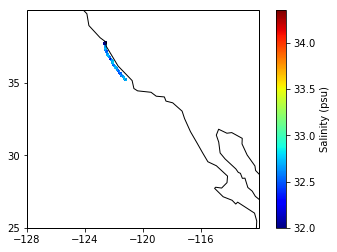

In [133]:
url = 'F:/data/cruise_data/saildrone/2018_wcoast/saildrone_west_coast_survey_2018_f374_2e74_3de8.nc'
ds_usv = xr.open_dataset(url)
ds_usv.close()
xlon =  ds_usv.longitude.copy(deep=True)
xlat =  ds_usv.latitude.copy(deep=True)
salinity =  ds_usv.SAL_MEAN.copy(deep=True)
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(xlon, xlat, s=3.0, c=salinity, edgecolor='none', cmap='jet',vmin=32,vmax=34.35)
ax.coastlines()
x1,x2,y1,y2 = -128,-112,25,40
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Salinity (psu)')
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/wcoast_location.png'
plt.savefig(fig_fname, transparent=False, format='png')


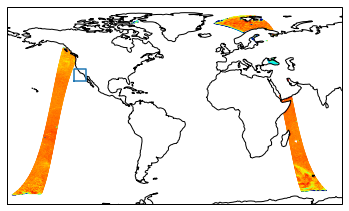

In [186]:
ds = xr.open_dataset(filelist[8])
ds.close()
x = ds.cellon[:,:,0].data
y = ds.cellat[:,:,0].data
z = ds.sss_smap[:,:,0].data
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(x, y, s=1.0, c=z, edgecolor='none', cmap='jet')
minlon,maxlon,minlat,maxlat = ds_usv.lon.min().data,ds_usv.lon.max().data,ds_usv.lat.min().data,ds_usv.lat.max().data
ax.plot([minlon,maxlon,maxlon,minlon,minlon],[minlat,minlat,maxlat,maxlat,minlat])
ax.coastlines()


In [153]:
#create daily data arrays
#grid the data and search within the in situ obs to find which filenames are in right region


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in remainder
  from ipykernel import kernelapp as app


In [148]:
#create daily data arrays
rlon=np.arange(-180,180,.25)
rlat=np.arange(90,-90,-.25)
area_def = load_area('areas.cfg', 'pc_world')
itime=0
for ilook in range(1):
    x,y,x2,y2 = [],[],[],[]
    if itime==1:
        z = z2 = np.empty(0, np.int32)
    else:
        z = z2 = np.empty(0, np.datetime64)    
    for file in filelist:
        ds = xr.open_dataset(file)
        ds.close()
        x = np.append(x,ds.cellon[:,:780,ilook].data)
        y = np.append(y,ds.cellat[:,:780,ilook].data)
        if itime==1:
            z = np.append(z,ds.sss_smap[:,:780,ilook].data)
        else:
            z = np.append(z,ds.time[:,:780,ilook].data)
        x2 = np.append(x2,ds.cellon[:,780:,ilook].data)
        y2 = np.append(y2,ds.cellat[:,780:,ilook].data)
        if itime==1:
            z2 = np.append(z2,ds.sss_smap[:,780:,ilook].data)
        else:
            z2 = np.append(z2,ds.time[:,780:,ilook].data)
    lons,lats,data = x,y,z 
    lons = np.mod(lons+180,360)-180
    swath_def = SwathDefinition(lons, lats)
    result1 = resample_nearest(swath_def, data, area_def, radius_of_influence=20000, fill_value=None)
    lons,lats,data = x2,y2,z2 
    lons = np.mod(lons+180,360)-180
    swath_def = SwathDefinition(lons, lats)
    result2 = resample_nearest(swath_def, data, area_def, radius_of_influence=20000, fill_value=None)
    tem = np.stack((result1,result2))
    das = xr.DataArray(tem,name='sss1',coords={'iasc':[0,1],'lat':rlat,'lon':rlon},dims=('iasc','lat','lon'))
    dat = xr.DataArray(tem,name='time',coords={'iasc':[0,1],'lat':rlat,'lon':rlon},dims=('iasc','lat','lon'))
ds_out = xr.Dataset({das,dat})


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in remainder


TypeError: Type <class 'numpy.datetime64'> is unsupported for masked fill values

In [147]:
ds_out = xr.Dataset({das,dat})
z=np.empty(0,np.datetime64)
print(type(z),type(ds.time[0,0,0].data))
z = np.append(z,ds.time[0,0,0].data)

<class 'numpy.ndarray'> <class 'numpy.datetime64'>


In [124]:
    da0 = xr.DataArray(result,name='sss0',coords={'lat':rlat,'lon':rlon},dims=('lat','lon'))

#iasc=0
#da1 = xr.DataArray(result,name='sss1',coords={'lat':rlat,'lon':rlon,'asc':iasc},dims=('lat','lon','asc'))


array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])

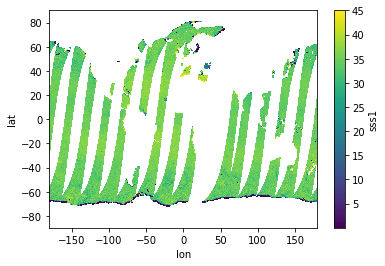

In [116]:
da1.plot()

In [102]:
lons = x #ds.cellon[:,:,0].data
lons = np.mod(lons+180,360)-180
lats = y# ds.cellat[:,:,0].data
data = z#ds.sss_smap[:,:,0].data
area_def = load_area('areas.cfg', 'pc_world')
swath_def = SwathDefinition(lons, lats)
result = resample_nearest(swath_def, data, area_def, radius_of_influence=20000, fill_value=None)
save_quicklook('sss.png', area_def, result, num_meridians=0, num_parallels=0, label='Salinity (psu)')

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in remainder
  


In [79]:
rlon=np.arange(-180,180,.25)
rlat=np.arange(90,-90,-.25)
da = xr.DataArray(result,name='sss0',coords={'lat':rlat,'lon':rlon},dims=('lat','lon'))

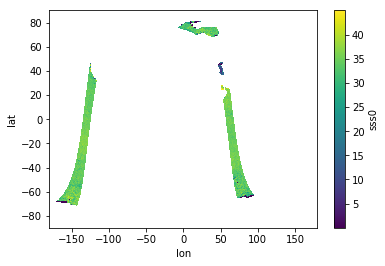

In [81]:
da.plot()

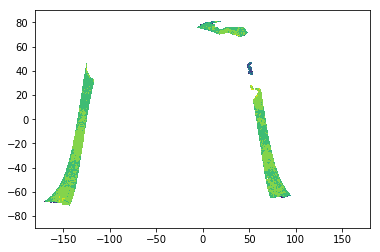

In [76]:
plt.contourf(rlon,rlat,result)

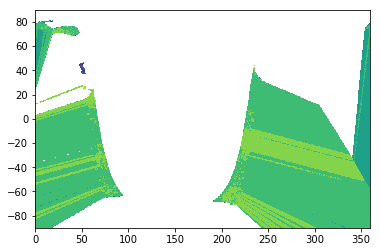

In [112]:
#interpolate onto grid
# data coordinates and values
idim = ds.cellon.shape[0]
jdim = ds.cellon.shape[1]
x = ds.cellon[:,:,0].data.reshape(idim*jdim)
y = ds.cellat[:,:,0].data.reshape(idim*jdim)
z = ds.sss_smap[:,:,0].data.reshape(idim*jdim)

mask = np.isfinite(x) & np.isfinite(y)
x = x[mask]
y = y[mask]
z = z[mask]

# target grid to interpolate to
xi,yi = np.arange(0,360,.5), np.arange(-90,90,.5)
xi,yi = np.meshgrid(xi,yi)

## set mask
#mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='nearest')

plt.contourf(xi,yi,zi)

In order to use open_mfdataset you need to either provide a path or a list of filenames to input

Here we use the USV cruise start and end date to read in all data for that period

# Read in SSS L2 data
Read in data using open_mfdataset with the option coords='minimal'

The dataset is printed out and you can see that rather than straight xarray data array for each of the data variables open_mfdataset using dask arrays

In [54]:
lon = np.arange(0,360)
np.mod(lon+180,360)-180
np.mod(lon + 180,360) - 180

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
         99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
        110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
        132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
        143,  144,  145,  146,  147,  148,  149,  1

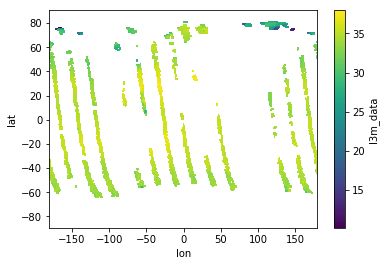

In [48]:
filename = 'f:/data/sat_data/aquarius/Q2011237.L3m_DAY_SCIA_V5.0.RAIN_MASK_SSS_1deg'
ds = xr.open_dataset(filename)
ds.close()
ds.coords['phony_dim_0']=np.arange(90,-90,-1)
ds.coords['phony_dim_1']=np.arange(-180,180)
ds = ds.rename({'phony_dim_0':'lat','phony_dim_1':'lon'})
ds.l3m_data.plot()

In [15]:
#ds_sat = xr.open_mfdataset(filelist,coords='minimal')
ds_sat = xr.open_dataset(filelist[0])
#ds_sat = ds_sat.isel(depth=0).drop('year').rename({'latitude':'lat'}).rename({'longitude':'lon'})
#ds_sat = ds_sat.sortby('lat').sel(lon=slice(20.0,379.00))
#ds_sat.coords['lon'] = (ds_sat.coords['lon'] + 180) % 360 - 180
#ds_sat = ds_sat.sortby('lon')
ds_sat.close()
print(ds_sat)  #check units 
ds_sat

<xarray.Dataset>
Dimensions:            (look: 2, polarization_2: 2, polarization_3: 3, polarization_4: 4, xdim_grid: 1560, ydim_grid: 720)
Dimensions without coordinates: look, polarization_2, polarization_3, polarization_4, xdim_grid, ydim_grid
Data variables:
    time               (ydim_grid, xdim_grid, look) datetime64[ns] ...
    cellat             (ydim_grid, xdim_grid, look) float32 ...
    cellon             (ydim_grid, xdim_grid, look) float32 ...
    gland              (ydim_grid, xdim_grid, look) float32 ...
    gice               (ydim_grid, xdim_grid) float32 ...
    sss_smap           (ydim_grid, xdim_grid, look) float32 ...
    surtep             (ydim_grid, xdim_grid) float32 ...
    winspd             (ydim_grid, xdim_grid) float32 ...
    sss_ref            (ydim_grid, xdim_grid) float32 ...
    iqc_flag           (ydim_grid, xdim_grid, look) int32 ...
    zang               (ydim_grid, xdim_grid, look) float32 ...
    alpha              (ydim_grid, xdim_grid, look) 

<xarray.Dataset>
Dimensions:            (look: 2, polarization_2: 2, polarization_3: 3, polarization_4: 4, xdim_grid: 1560, ydim_grid: 720)
Dimensions without coordinates: look, polarization_2, polarization_3, polarization_4, xdim_grid, ydim_grid
Data variables:
    time               (ydim_grid, xdim_grid, look) datetime64[ns] ...
    cellat             (ydim_grid, xdim_grid, look) float32 ...
    cellon             (ydim_grid, xdim_grid, look) float32 ...
    gland              (ydim_grid, xdim_grid, look) float32 ...
    gice               (ydim_grid, xdim_grid) float32 ...
    sss_smap           (ydim_grid, xdim_grid, look) float32 ...
    surtep             (ydim_grid, xdim_grid) float32 ...
    winspd             (ydim_grid, xdim_grid) float32 ...
    sss_ref            (ydim_grid, xdim_grid) float32 ...
    iqc_flag           (ydim_grid, xdim_grid, look) int32 ...
    zang               (ydim_grid, xdim_grid, look) float32 ...
    alpha              (ydim_grid, xdim_grid, look) 


1. First let's subset the data to make it smaller to deal with by using the cruise lat/lons




In [8]:
#Step 1 from above
subset = ds_sat.sel(lon=slice(ds_usv_subset.lon.min().data,ds_usv_subset.lon.max().data),
                    lat=slice(ds_usv_subset.lat.min().data,ds_usv_subset.lat.max().data))

#now collocate with usv lat and lons
ds_collocated = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='linear')
ds_collocated_nearest = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='nearest')


# A larger STD that isn't reflective of uncertainty in the observation
The collocation above will result in multiple USV data points matched with a single satellite
observation.    The USV is sampling every 1 min and approximately few meters, while the satellite
is an average over a footprint that is interpolated onto a daily mean map.  While calculating the mean would results in a valid mean, the STD would be higher and consist of a component that reflects the uncertainty of the USV and the satellite and a component that reflects the natural variability in the region that is sampled by the USV

Below we use the 'nearest' collocation results to identify when multiple USV data are collcated to
a single satellite observation.
This code goes through the data and creates averages of the USV data that match the single CCMP collocated value.


In [9]:
ilen,index = ds_collocated_nearest.dims['time'],0
ds_tem = ds_collocated_nearest.copy(deep=True)
duu, duv1, duv2, dlat, dlon, dut = [],[],[],[],[],np.empty((),dtype='datetime64')
while index <= ilen-2:
    index += 1
    if np.isnan(ds_collocated_nearest.u[index]):
        continue
    if np.isnan(ds_tem.u[index]):
        continue
   # print(index, ilen)
    iend = index + 730
    if iend > ilen-1:
        iend = ilen-1
    ds_tem_subset = ds_tem.u[index:iend]
    ds_tem_subset2 = ds_tem.v[index:iend]
    ds_usv_subset2ucur = ds_usv_subset.vel_east_30m[index:iend]
    ds_usv_subset2vcur = ds_usv_subset.vel_north_30m[index:iend]
    ds_usv_subset2lat = ds_usv_subset.lat[index:iend]
    ds_usv_subset2lon = ds_usv_subset.lon[index:iend]
    ds_usv_subset2time = ds_usv_subset.time[index:iend]
    cond = ((ds_tem_subset==ds_collocated_nearest.u[index]) & (ds_tem_subset2==ds_collocated_nearest.v[index]))
    notcond = np.logical_not(cond)
    #cond = ((ds_tem.analysed_sst==ds_collocated_nearest.analysed_sst[index]))
    #notcond = np.logical_not(cond)
    masked = ds_tem_subset.where(cond)
    if masked.sum().data==0:  #don't do if data not found
        continue
    masked_usvucur = ds_usv_subset2ucur.where(cond,drop=True)
    masked_usvvcur = ds_usv_subset2vcur.where(cond,drop=True)
    masked_usvlat = ds_usv_subset2lat.where(cond,drop=True)
    masked_usvlon = ds_usv_subset2lon.where(cond,drop=True)
    masked_usvtime = ds_usv_subset2time.where(cond,drop=True)
    duu=np.append(duu,masked_usvucur.mean().data)
    duv1=np.append(duv1,masked_usvvcur.mean().data)
    dlat=np.append(dlat,masked_usvlat.mean().data)
    dlon=np.append(dlon,masked_usvlon.mean().data)
    tdif = masked_usvtime[-1].data-masked_usvtime[0].data
    mtime=masked_usvtime[0].data+np.timedelta64(tdif/2,'ns')
#    if mtime>dut.max():
#        print(index,dut.shape[0],masked_usvtime[0].data,masked_usvtime[-1].data-masked_usvtime[0].data)
    dut=np.append(dut,mtime)
    ds_tem.u[index:iend]=ds_tem.u.where(notcond)
    ds_tem.v[index:iend]=ds_tem.v.where(notcond)
dut2 = dut[1:]  #remove first data point which is a repeat from what array defined       
ds_new=xr.Dataset(data_vars={'vel_east': ('time',duu),'vel_north':('time',duv1),
                             'lon': ('time',dlon),
                             'lat': ('time',dlat)},
                  coords={'time':dut2})
ds_new.to_netcdf('F:/data/cruise_data/saildrone/baja-2018/oscar_downsampled_usv_data2.nc')

# redo the collocation
Now, redo the collocation, using 'linear' interpolation using the averaged data.  This will interpolate the data temporally onto the USV sampling which has been averaged to the satellite data grid points

In [10]:
ds_collocated_averaged = subset.interp(lat=ds_new.lat,lon=ds_new.lon,time=ds_new.time,method='linear')
ds_collocated_averaged

<xarray.Dataset>
Dimensions:  (time: 162)
Coordinates:
    depth    float32 15.0
    lat      (time) float64 37.58 37.32 37.38 36.97 ... 37.3 37.45 37.55 37.64
    lon      (time) float64 -122.7 -122.8 -122.9 -122.7 ... -123.1 -122.9 -122.8
  * time     (time) datetime64[ns] 2018-04-12 ... 2018-06-10T17:55:00
Data variables:
    u        (time) float64 0.02423 0.04211 0.04228 ... -0.05069 -0.0574
    v        (time) float64 0.003738 -0.0401 -0.04799 ... -0.02103 -0.03263
    um       (time) float64 0.02423 0.04211 0.04228 ... -0.05069 -0.0574
    vm       (time) float64 0.003738 -0.0401 -0.04799 ... -0.02103 -0.03263
Attributes:
    VARIABLE:       Ocean Surface Currents
    DATATYPE:       1/72 YEAR Interval
    DATASUBTYPE:    unfiltered
    GEORANGE:       20 to 420 -80 to 80
    PERIOD:         Jan.01,2018 to Dec.26,2018
    year:           2018
    description:    OSCAR Third Degree Sea Surface Velocity
    CREATION_DATE:  03:39 30-Jan-2019
    version:        2009.0
    source:  

In [38]:
ds_collocated_averaged.to_netcdf('F:/data/cruise_data/saildrone/baja-2018/oscar_downsampled_collocated_usv_data3.nc')


In [42]:
ds_collocated_averaged['spd']=np.sqrt(ds_collocated_averaged.u**2+ds_collocated_averaged.v**2)
ds_new['spd'] = np.sqrt(ds_new.vel_east**2+ds_new.vel_north**2)
ds_collocated_averaged['dir']=np.arctan2(ds_collocated_averaged.v,ds_collocated_averaged.u)*180./np.pi
ds_new['dir'] = np.arctan2(ds_new.vel_north,ds_new.vel_east)*180./np.pi

usv_spd = ds_new.spd
sat_spd = ds_collocated_averaged.spd
usv_dir = ds_new.dir
sat_dir = ds_collocated_averaged.dir
dif_spd,dif_dir = usv_spd - sat_spd, usv_dir - sat_dir
cond,cond2 = (dif_dir > 180),(dif_dir < -180)
cond,cond2 = (dif_dir > 180),(dif_dir < -180)
dif_dir[cond]-=360
dif_dir[cond2]+=360
print('mean,std dif speed',[dif_spd.mean().data,dif_spd.std().data])
print('mean,std dir',[dif_dir.mean().data,dif_dir.std().data,dif_spd.shape[0]])

usv_spd = ds_new.spd
sat_spd = ds_collocated_averaged.spd
usv_dir = ds_new.dir
sat_dir = ds_collocated_averaged.dir
dif_spd,dif_dir = usv_spd - sat_spd, usv_dir - sat_dir
cond,cond2 = (dif_dir > 180),(dif_dir < -180)
cond,cond2 = (dif_dir > 180),(dif_dir < -180)
dif_dir[cond]-=360
dif_dir[cond2]+=360

cond = (np.isfinite(usv_spd) & np.isfinite(sat_spd))
usv_spd = usv_spd[cond]
sat_spd = sat_spd[cond]
usv_dir = usv_dir[cond]
sat_dir = sat_dir[cond]

sdif = dif_spd.dropna('time')
sdifcor = np.corrcoef(sat_spd,usv_spd)[0,1]
std_robust = np.nanmedian(np.abs(sdif - np.nanmedian(sdif))) * 1.482602218505602
ilen = sdif.shape[0]
print([sdif.mean().data,sdif.median().data,sdifcor,sdif.std().data,std_robust,
                    np.abs(sdif).mean().data,sdif.shape[0]])
sdif = dif_dir.dropna('time')
sdifcor = np.corrcoef(sat_dir,usv_dir)[0,1]
std_robust = np.nanmedian(np.abs(sdif - np.nanmedian(sdif))) * 1.482602218505602
ilen = sdif.shape[0]
print([sdif.mean().data,sdif.median().data,sdifcor,sdif.std().data,std_robust,
                    np.abs(sdif).mean().data,sdif.shape[0]])


mean,std dif speed [array(0.11182869), array(0.11352103)]
mean,std dir [array(-0.40261571), array(62.62654293), 162]
[array(0.11182869), array(0.08802241), 0.4459301398989154, array(0.11352103), 0.09906482143580654, array(0.12003823), 152]
[array(-0.40261571), array(1.83418634), 0.343404240006346, array(62.62654293), 43.999699068779684, array(45.96577433), 152]


In [43]:
ds_new

<xarray.Dataset>
Dimensions:    (time: 162)
Coordinates:
  * time       (time) datetime64[ns] 2018-04-12 ... 2018-06-10T17:55:00
Data variables:
    vel_east   (time) float64 0.04564 0.1427 0.05204 ... 0.06883 -0.01579
    vel_north  (time) float64 0.02064 -0.09476 -0.01621 ... -0.1755 -0.09313
    lon        (time) float64 -122.7 -122.8 -122.9 ... -123.1 -122.9 -122.8
    lat        (time) float64 37.58 37.32 37.38 36.97 ... 37.3 37.45 37.55 37.64
    spd        (time) float64 0.05008 0.1713 0.05451 ... 0.3585 0.1885 0.09446
    dir        (time) float64 24.33 -33.59 -17.31 ... -85.86 -68.58 -99.62

0.16125791974845208 0.06255530115918748 0.4459301398989154 8.539846478765322e-09 0.02642801320604377


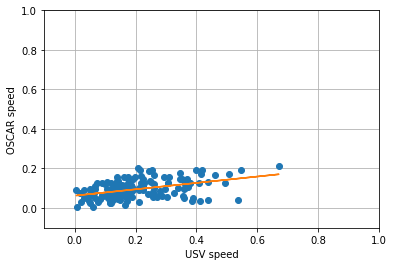

In [47]:

# Learn about API authentication here: https://plot.ly/python/getting-started
# Find your api_key here: https://plot.ly/settings/api
# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

usv_spd = ds_new.spd
sat_spd = ds_collocated_averaged.spd
usv_dir = ds_new.dir
sat_dir = ds_collocated_averaged.dir
dif_spd,dif_dir = usv_spd - sat_spd, usv_dir - sat_dir
cond,cond2 = (dif_dir > 180),(dif_dir < -180)
cond,cond2 = (dif_dir > 180),(dif_dir < -180)
dif_dir[cond]-=360
dif_dir[cond2]+=360

usv_ucur = ds_new.vel_east
usv_vcur = ds_new.vel_north
sat_ucur = ds_collocated_averaged.u
sat_vcur = ds_collocated_averaged.v
usv_spd  = np.sqrt(usv_ucur**2 + usv_vcur**2)
sat_spd  = np.sqrt(sat_ucur**2 + sat_vcur**2)

cond = (np.isfinite(usv_spd) & np.isfinite(sat_spd))
usv_spd = usv_spd[cond]
sat_spd = sat_spd[cond]
usv_dir = usv_dir[cond]
sat_dir = sat_dir[cond]

xi = usv_spd.data
A = array([ xi, ones(sat_spd.shape[0])])
y = sat_spd.data
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept
plt.plot(xi,y,'o', xi, line)
plt.ylim(-.1,1),plt.xlim(-.1,1)
plt.grid()
plt.xlabel('USV speed')
plt.ylabel('OSCAR speed')
print(slope,intercept,r_value,p_value,std_err)

fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/oscar_usv_big_spd.png'
plt.savefig(fig_fname, transparent=False, format='png')

#pylab.title('Linear Fit with Matplotlib')
#ax = plt.gca()
#ax.set_axis_bgcolor((0.898, 0.898, 0.898))
#fig = plt.gcf()
#py.plot_mpl(fig, filename='linear-Fit-with-matplotlib')



0.27658743543252745 -0.0011923887293564675 0.6666748494328402 1.2526145088554306e-20 0.025418329264844764
0.25503904326658766 -0.026807894258679858 0.5685313728861343 3.2225116457853236e-14 0.030334901843883065
0.17560735742603198 0.060752692787064695 0.4827181530373511 3.9579624327693986e-10 0.026188531117316994


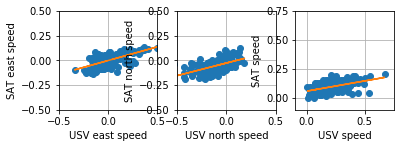

In [46]:
usv_ucur = ds_new.vel_east
usv_vcur = ds_new.vel_north
sat_ucur = ds_collocated_averaged.u
sat_vcur = ds_collocated_averaged.v

cond = (np.isfinite(usv_ucur) & np.isfinite(sat_ucur) & ( usv_vcur<.2))
usv_ucur = usv_ucur[cond]
sat_ucur = sat_ucur[cond]
usv_vcur = usv_vcur[cond]
sat_vcur = sat_vcur[cond]

xi = usv_ucur.data
A = array([ xi, ones(usv_ucur.shape[0])])
y = sat_ucur.data
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept
plt.subplot(231)
plt.plot(xi,y,'o', xi, line)
plt.ylim(-.5,.5),plt.xlim(-.5,.5)
plt.grid()
plt.xlabel('USV east speed')
plt.ylabel('SAT east speed')
print(slope,intercept,r_value,p_value,std_err)
xi = usv_vcur.data
A = array([ xi, ones(usv_vcur.shape[0])])
y = sat_vcur.data
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept
plt.subplot(232)
plt.plot(xi,y,'o', xi, line)
plt.xlabel('USV north speed')
plt.ylabel('SAT north speed')
print(slope,intercept,r_value,p_value,std_err)
plt.ylim(-.5,.5),plt.xlim(-.5,.5)
plt.grid()
xi = np.sqrt(usv_vcur.data**2 + usv_ucur.data**2)
A = array([ xi, ones(usv_vcur.shape[0])])
y = np.sqrt(sat_vcur.data**2+sat_ucur.data**2)
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept
plt.subplot(233)
plt.plot(xi,y,'o', xi, line)
plt.ylim(-.1,.75),plt.xlim(-.1,.75)
plt.grid()
plt.xlabel('USV speed')
plt.ylabel('SAT speed')
print(slope,intercept,r_value,p_value,std_err)
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/sat_current_U_V_speed.png'
plt.savefig(fig_fname, transparent=False, format='png')


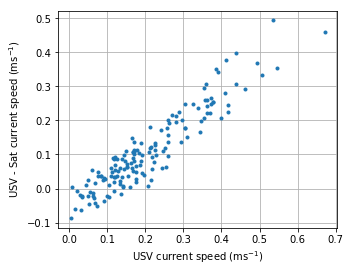

In [34]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(usv_spd,usv_spd - sat_spd,'.')
ax.grid(True)
ax.set_xlabel('USV current speed (ms$^{-1}$)')
ax.set_ylabel('USV - Sat current speed (ms$^{-1}$)')
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/sat_current_USV_minus_Sat_fnct_USV.png'
fig.savefig(fig_fname, transparent=False, format='png')


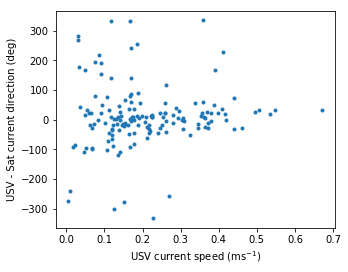

In [33]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(usv_spd,usv_dir - sat_dir,'.')
ax.set_xlabel('USV current speed (ms$^{-1}$)')
ax.set_ylabel('USV - Sat current direction (deg)')
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/sat_current_both_bias.png'
fig.savefig(fig_fname, transparent=False, format='png')


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


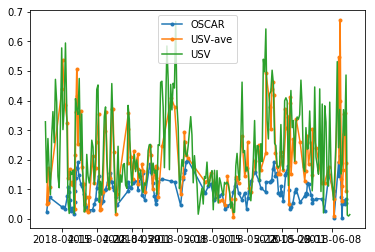

In [29]:
ds_usv_subset['cur_spd']=np.sqrt(ds_usv_subset.vel_east**2+ds_usv_subset.vel_north**2)
ds_usv_6hr=ds_usv_subset.resample(time='6H').mean()
ds_usv_6hr['cur_spd']=np.sqrt(ds_usv_6hr.vel_east**2+ds_usv_6hr.vel_north**2)


plt.plot(ds_collocated_averaged.time[cond],sat_spd,'.-')
plt.plot(ds_collocated_averaged.time[cond],usv_spd,'.-')
plt.plot(ds_usv_6hr.time,ds_usv_6hr.cur_spd)
plt.legend({'OSCAR','USV','USV-ave'})
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/sat_current_timeseries_bias.png'
fig.savefig(fig_fname, transparent=False, format='png')


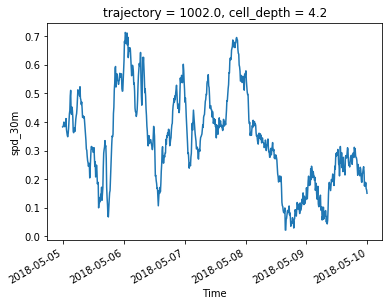

In [30]:
ds_usv.spd_30m.sel(time=slice('2018-05-05','2018-05-09')).plot()
